In [343]:
import os
import numpy as np
import pandas as pd
from os.path import join, expanduser
from matplotlib import pyplot as plt
from datetime import datetime

In [380]:
class ParseLine():
    def __init__(self, oneline, examples=False):        
        self.oneline = oneline.split('\t')
        if not examples:
            self.oneline = [self.oneline[0]] + [float(x) for x in self.oneline[1:]]
        else:
            if len(self.oneline)>1:
                self.oneline = [self.oneline[0]] + [float(x) for x in self.oneline[3:]+[self.oneline[2]]]
        
    @property
    def get_file(self):
        return self.oneline[0]
        
    @property
    def get_example(self):
        return self.oneline[4]
    
    @property
    def get_cb(self):
        return self.oneline[1]
        
    @property
    def get_igl(self):
        return self.oneline[2]
    
    @property
    def get_igl_inv(self):
        return self.oneline[3]

In [381]:
class ParseFile(ParseLine):
    def __init__(self, filename='results_file',with_examples=False, with_cb_flip=False):  
        self.with_examples = with_examples
        
        with open(filename, 'rb+') as f:
            lines = f.readlines()
        self.lines = [x.strip().decode() for x in lines  if not 'n.a.' in x.decode()]
        if with_examples:
            self.header = self.lines[:5]+[self.lines[-1]]
            self.lines = self.lines[5:-1]
            self.examples = []
            if with_cb_flip:
                self.cb_flip=[]
        
        self.processed = {}
        self.files = []
        self.cb_loss = []
        self.igl_loss = []
        self.igl_inv_loss = []
        
    def __call__(self):
        i=1
        for line in self.lines:
            i+=1
            thisline = ParseLine(line, self.with_examples)
            if len(thisline.oneline) <2 or 'n.a.' in thisline.oneline:
                continue
            self.files.append(thisline.get_file)
            self.cb_loss.append(thisline.get_cb)
            self.igl_loss.append(thisline.get_igl)
            self.igl_inv_loss.append(thisline.get_igl_inv)
            if self.with_examples:
                self.examples.append(thisline.get_example)
        self.processed = dict(files=self.files, examples=self.examples, cb=self.cb_loss,
                         igl=self.igl_loss, igl_inv=self.igl_inv_loss)

### Load Datasets and Define Global Variables

In [382]:
winsize =(16,6)
linewidth = 6
save = True
labelsize = 16
fontdict = {'fontsize':12, 'fontweight':'bold'}
colors = ['blue', 'red', 'yellow', 'orange', 'green', 'black']

filename='result_2021-08-18_02:05:45.dat'  #'result_2021-08-17_03:28:13.dat'
pf = ParseFile(filename, True)
pf()

refined = 'result_pathological.dat'
pf2 = ParseFile(refined, True)
pf2()

In [389]:
for x in [pf.cb_loss, pf.igl_loss, pf.igl_inv_loss]:
    prod = np.asarray(pf.examples) * (1-np.asarray(x))
    print(sum(prod)/sum(pf.examples))

0.4615425693656812
0.4437562811390282
0.4438666430115347


### Basic CDF

In [349]:
def cdf_plotter(ax, data, label='CB Loss CDF', linestyle='-.', color='blue'):
    hist, bin_edges = np.histogram(data, density=True)
    diff = bin_edges[1]-bin_edges[0]
    cum = np.cumsum(hist)*diff

    ax.plot(bin_edges[1:], 100*cum, label=label, color=color, linestyle=linestyle, linewidth='4')
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    ax.set_xlim([0.15, 1.0])
    ax.set_ylim([6, 100.0])
    ax.set_title('Cummulative Density Function (398 Datasets with classes, $K>2$)', fontdict)
    ax.set_xlabel('Relative Progressive Validation Loss', fontdict= {'fontsize': 16, 'fontweight': 'bold'})
    ax.grid('on')
    ax.legend(fontsize=10)
    ax.legend(fancybox=True, framealpha=0.5, #bbox_to_anchor=(0, 0.95),
                     borderaxespad=0., scatterpoints=1, ncol=1,
                     loc='upper left', fontsize=20)

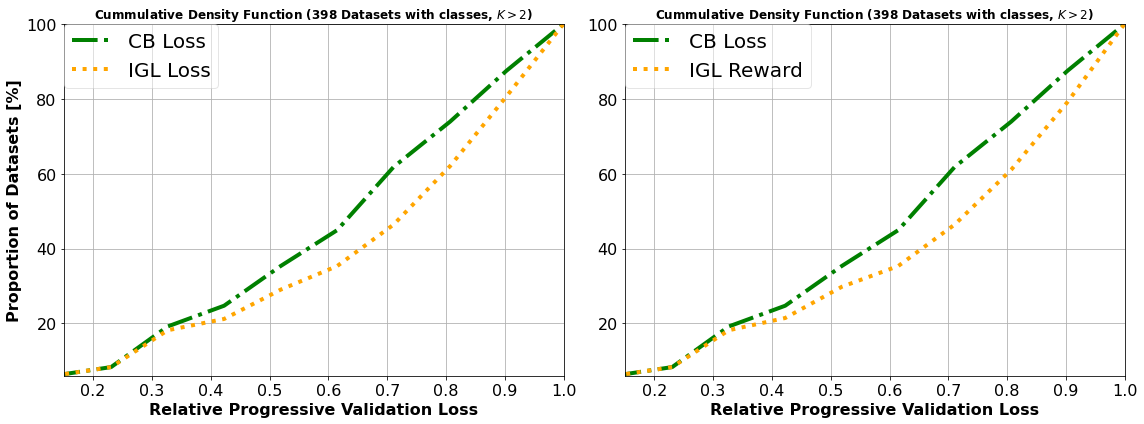

In [350]:
fig = plt.figure(figsize=winsize)

ax = fig.add_subplot(1, 2, 1)
cdf_plotter(ax, pf.cb_loss, label='CB Loss', linestyle='-.', color=colors[4])
cdf_plotter(ax, pf.igl_loss, label='IGL Loss', linestyle='dotted', color=colors[3])
ax.set_ylabel('Proportion of Datasets [%]', fontdict= {'fontsize': 16, 'fontweight': 'bold'})

ax = fig.add_subplot(1, 2, 2)
cdf_plotter(ax, pf.cb_loss, label='CB Loss', linestyle='-.', color=colors[4])
cdf_plotter(ax, pf.igl_inv_loss, label='IGL Reward', linestyle='dotted', color=colors[3])
ax.set_xlabel('Relative Progressive Validation Loss', fontdict= {'fontsize': 16, 'fontweight': 'bold'})

fig.tight_layout()
datetrained=filename.split('/')[-1].split('_')
datetrained = datetrained[1]+datetrained[-1].split('.')[0]

fig.tight_layout()
if save:
    plt.savefig(f'cdf_only_{datetrained}.jpg', dpi=79)
plt.show()

### Correlation Plot

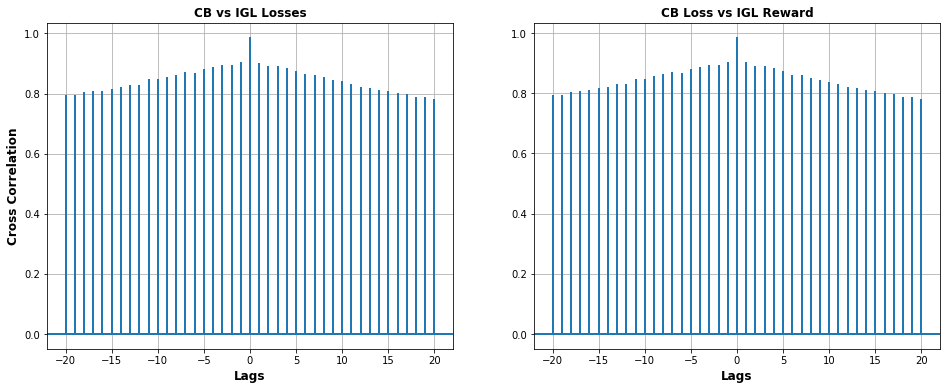

In [351]:
fig = plt.figure(figsize=winsize)

def plot_corr(ax, data, label='CB Loss vs. IGL Loss', title='CB vs IGL Losses', ylabel='Loss'):
    ax.xcorr(data[:,0], data[:,1], usevlines=True, normed=True, maxlags=20, lw=2, label=label)
    ax.set_title(title, fontdict)
    ax.set_xlabel('Lags', fontdict=fontdict)
    ax.grid('on')
#     ax.legend(fancybox=True, framealpha=0.5, #bbox_to_anchor=(20, 0.95),
#                      borderaxespad=0., scatterpoints=1, ncol=1,
#                      loc='upper left', fontsize=20)

ax = fig.add_subplot(1, 2, 1)
data = np.vstack((pf.cb_loss, pf.igl_loss)).T
ax.set_ylabel('Cross Correlation', fontdict=fontdict)
plot_corr(ax, data)

ax2 = fig.add_subplot(1, 2, 2)
data = np.vstack((pf.cb_loss, pf.igl_inv_loss)).T
plot_corr(ax2, data, label='CB Loss vs. IGL Reward', title='CB Loss vs IGL Reward')
if save:
    plt.savefig(f'cross_corr_{datetrained}.jpg', dpi=79)
plt.show()

### Do Scatter Plot

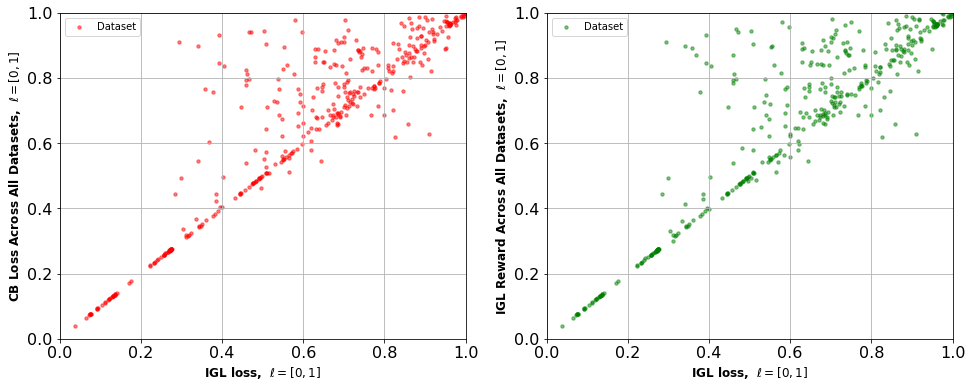

In [352]:
def scatter(ax, data, ex, label='CB vs IGL', labelsize=16, color='blue', title='CB vs IGL'):
    z = ex #np.arange(len(data))
    ax.scatter(data[:, 0], data[:,1], s=45, c=color, marker=".", alpha=0.5, label=label, cmap='viridis')
    ax.plot(z, linewidth=4, linestyle='--', color='k')
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_title(title, fontdict)
    ax.set_xlabel('IGL loss,  $\ell=[0, 1]$', fontdict=fontdict)
    ax.grid('on') 
    ax.legend()
#     ax.legend(fancybox=True, framealpha=0.5, #bbox_to_anchor=(0, 0.0),
#                      borderaxespad=0., scatterpoints=1, ncol=1,
#                      loc='upper left', fontsize=20)  

fig = plt.figure(figsize=winsize)
ax = fig.add_subplot(121)
data = np.vstack((pf.cb_loss, pf.igl_loss)).T
scatter(ax, data, pf.examples, color='red', title='',label='Dataset') # Number of Datasets
ax.set_ylabel('CB Loss Across All Datasets,  $\ell=[0, 1]$', fontdict=fontdict)

ax = fig.add_subplot(122)
data = np.vstack((pf.cb_loss, pf.igl_inv_loss)).T
scatter(ax, data, pf.examples, color='green', title='',label='Dataset')
ax.set_ylabel('IGL Reward Across All Datasets,  $\ell=[0, 1]$', fontdict=fontdict)
if save:
    plt.savefig(f'scatter_{datetrained}.jpg', dpi=79)
plt.show()

In [353]:
def dvh_like(ax, data, label='CB Loss CDF', linestyle='-.', color='blue', title='CB vs IGL',linewidth='4', fontdict= {'fontsize': 14, 'fontweight': 'bold'}):
    hist,bins = np.histogram(data,bins=500,range=(min(data), max(data)))
    temp = (hist.cumsum()*100.0/len(data))
    ax.plot(bins[:-1],temp,label=label, color=color, linestyle=linestyle, linewidth=linewidth)
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    ax.set_xlim([0.2, 1.0])
    ax.set_ylim([7, 100.0])
    ax.set_title(title, fontdict)
    ax.set_xlabel('Relative Progressive Validation Loss,  $\ell=[0, 1]$', fontdict=fontdict)
    ax.grid('on') 
    ax.legend(fancybox=True, framealpha=0.5, #bbox_to_anchor=(0, 0.0),
                     borderaxespad=0., scatterpoints=1, ncol=1,
                     loc='upper left', fontsize=15)  
    

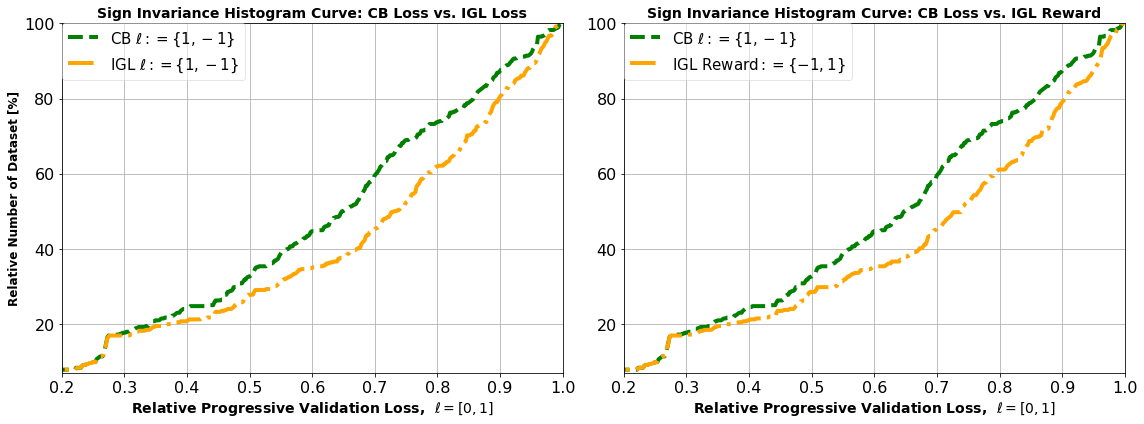

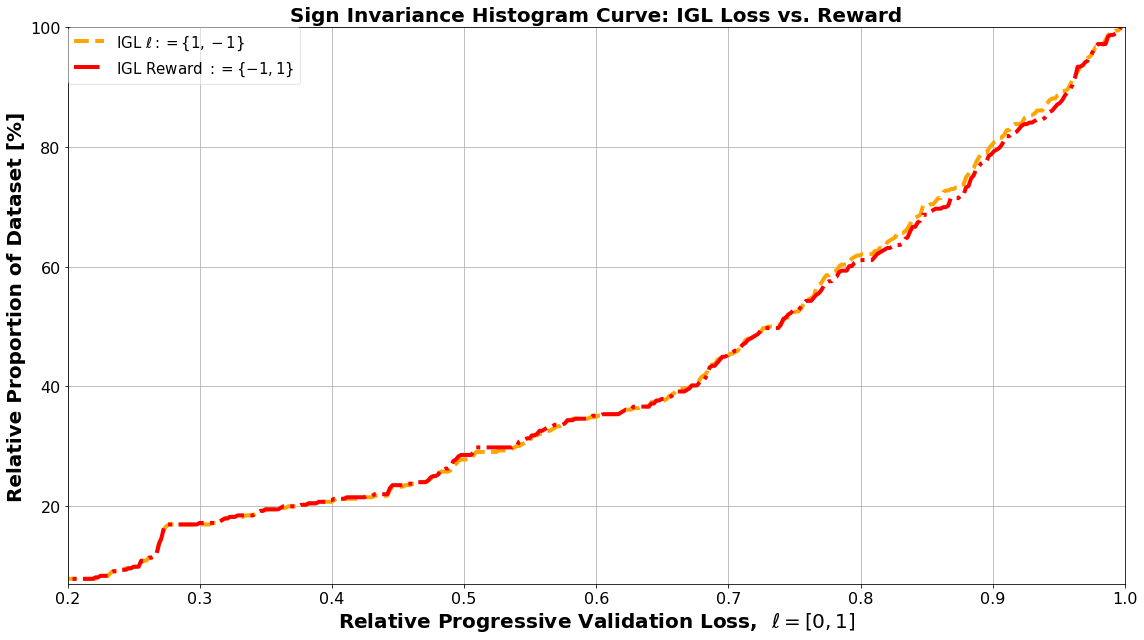

In [354]:
fig = plt.figure(figsize=winsize)
ax = fig.add_subplot(1, 2, 1)
dvh_like(ax, pf.cb_loss, label='CB $\ell:=\{1, -1\}$', linestyle='--', color=colors[4])
dvh_like(ax, pf.igl_loss, label='IGL $\ell:=\{1, -1\}$', linestyle='-.', color=colors[3], title='Sign Invariance Histogram Curve: CB Loss vs. IGL Loss')
ax.set_ylabel('Relative Number of Dataset [%]', fontdict)

ax = fig.add_subplot(1, 2, 2)
dvh_like(ax, pf.cb_loss, label='CB $\ell:=\{1, -1\}$', linestyle='--', color=colors[4], title='Sign Invariance Histogram Curve: CB Loss vs. IGL Reward')
dvh_like(ax, pf.igl_inv_loss, label='IGL Reward$:=\{-1, 1\}$', linestyle='-.', color=colors[3], \
         title='Sign Invariance Histogram Curve: CB Loss vs. IGL Reward')
fig.tight_layout()

datetrained=filename.split('/')[-1].split('_')
datetrained = datetrained[1]+datetrained[-1].split('.')[0]

if save:
    plt.savefig(f'cb_igl_dvh_{datetrained}.jpg', dpi=79)
plt.show()


# Now show just IGL and IGL Inverted alone
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)
dvh_like(ax, pf.igl_loss, label='IGL $\ell:=\{1, -1\}$', linestyle='--', color=colors[3], title='Sign Invariance Histogram Curve: IGL Loss vs. Reward')
dvh_like(ax, pf.igl_inv_loss, label='IGL Reward $:=\{-1, 1\}$', linestyle='-.', color=colors[1], \
         title='Sign Invariance Histogram Curve: IGL Loss vs. Reward', fontdict= {'fontsize': 20, 'fontweight': 'bold'})
ax.set_ylabel('Relative Proportion of Dataset [%]', fontdict= {'fontsize': 20, 'fontweight': 'bold'})
fig.tight_layout()

datetrained=filename.split('/')[-1].split('_')
datetrained = datetrained[1]+datetrained[-1].split('.')[0]

if save:
    plt.savefig(f'igl_igl_dvh_{datetrained}.jpg', dpi=79)
plt.show()

In [355]:
def example_plot(ax, data, examples, label='CB Loss CDF', linestyle='-.', color='blue', title='CB vs IGL',linewidth='4', fontdict= {'fontsize': 14, 'fontweight': 'bold'}):
    hist,bins = np.histogram(data,bins=500,range=(min(data), max(data)))
    temp = (hist.cumsum()*100.0/len(data))
#     ax.plot(bins[:-1],temp,label=label, color=color, linestyle=linestyle, linewidth=linewidth)
    ax.scatter(data, examples,label=label, color=color, linestyle=linestyle, linewidth=linewidth)
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 100.5])
    ax.set_title(title, fontdict)
    ax.set_xlabel('Relative Validation Loss,  $\ell=[0, 1]$', fontdict=fontdict)
    ax.grid('on') 
    ax.legend(fancybox=True, framealpha=0.5, #bbox_to_anchor=(0, 0.0),
                     borderaxespad=0., scatterpoints=1, ncol=1,
                     loc='upper left', fontsize=15)      

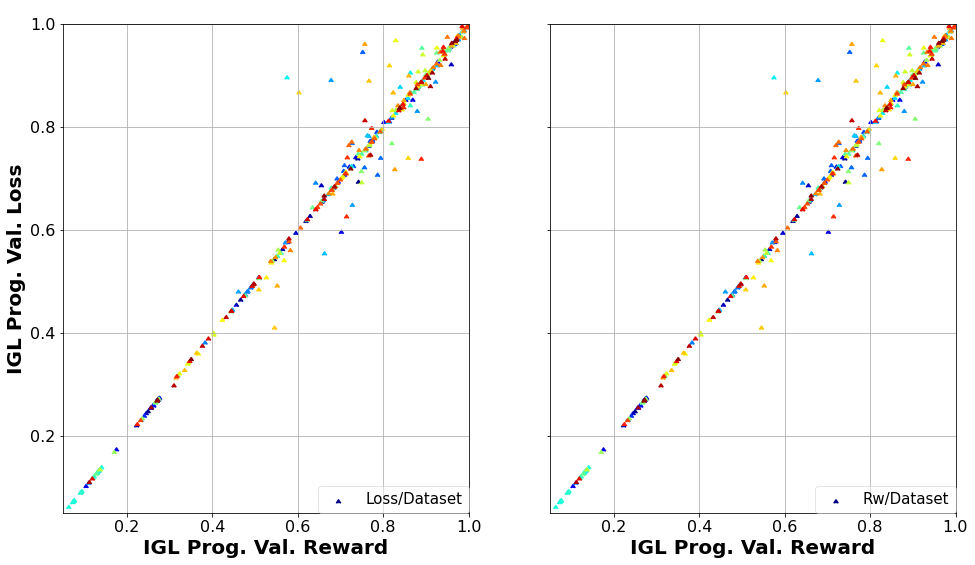

In [356]:
def scatter_plot(ax, x, y, z, label='CB Loss CDF', linestyle='-.', color='blue', title='CB vs IGL',linewidth='4', fontdict= {'fontsize': 14, 'fontweight': 'bold'}):
    ax.scatter(x, y, 20, c=range(len(x)), marker=6, cmap='jet', label=label, alpha=1)
    #ax.plot([z],label='best fit', color='k', linestyle=linestyle, linewidth=linewidth)
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    ax.set_xlim([0.05, 1.0])
    ax.set_ylim([0.05, 1.])
    ax.set_title(title, fontdict)
    ax.set_xlabel('IGL Prog. Val. Reward', fontdict= {'fontsize': 20, 'fontweight': 'bold'})
    ax.grid('on') 
    ax.legend(fancybox=True, framealpha=0.5, #bbox_to_anchor=(0, 0.0),
                     borderaxespad=0., scatterpoints=1, ncol=1,
                     loc='lower right', fontsize=15)  

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9), sharey=True)    
scatter_plot(ax1, pf.igl_loss, pf.igl_inv_loss, pf.cb_loss, color='r', label='Loss/Dataset', title='')  
ax1.set_ylabel('IGL Prog. Val. Loss', fontdict= {'fontsize': 20, 'fontweight': 'bold'})


scatter_plot(ax2, pf.igl_loss, pf.igl_inv_loss, pf.cb_loss, color='b', label='Rw/Dataset', title=' ')
# ax2.set_ylabel('IGL Prog. Val. Reward', fontdict= {'fontsize': 20, 'fontweight': 'bold'})
if save:
    plt.savefig(f'scatter_{datetrained}.jpg', dpi=79)
plt.show()

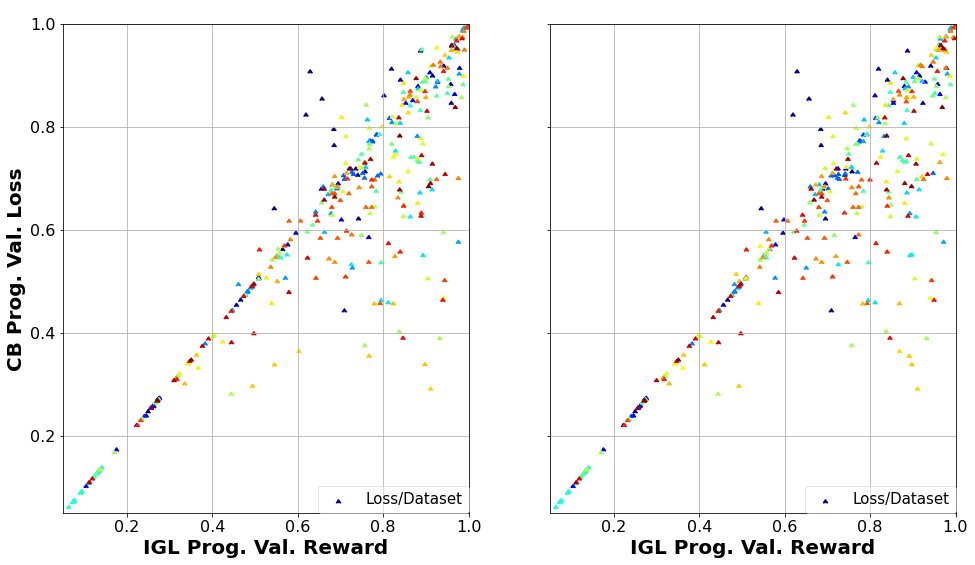

In [357]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9), sharey=True)    
scatter_plot(ax1, pf.igl_loss, pf.cb_loss, pf.igl_inv_loss, color='r', label='Loss/Dataset', title='')  
ax1.set_ylabel('CB Prog. Val. Loss', fontdict= {'fontsize': 20, 'fontweight': 'bold'})


scatter_plot(ax2, pf.igl_inv_loss, pf.cb_loss, pf.igl_loss, color='b', label='Loss/Dataset', title=' ')
# ax2.set_ylabel('IGL Prog. Val. Reward', fontdict= {'fontsize': 20, 'fontweight': 'bold'})
if save:
    plt.savefig(f'scatter_{datetrained}.jpg', dpi=79)
plt.show()

In [358]:
pf.files[0].split('_')[-1].split('.')[0]

'10'

In [359]:
print([np.mean(x) for x in ( pf.igl_loss, pf.cb_loss, pf.igl_inv_loss)])
print([np.std(x) for x in ( pf.igl_loss, pf.cb_loss, pf.igl_inv_loss)])

[0.6578272626262626, 0.6050781287878788, 0.6598160000000001]
[0.26763921325985707, 0.25405252031691167, 0.2701575627427652]


### Box Plots

No handles with labels found to put in legend.


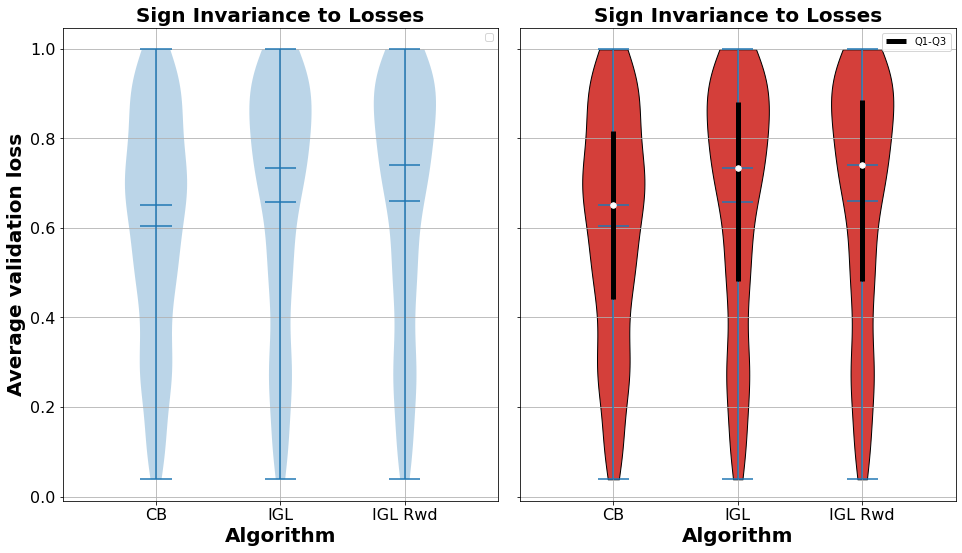

In [360]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Algorithm', fontdict=fontdict)

fontdict={'fontsize':20, 'fontweight': 'bold'}

# create test data
np.random.seed(19680801)
data = [pf.cb_loss, pf.igl_loss, pf.igl_inv_loss]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9), sharey=True)

ax1.set_title('Sign Invariance to Losses', fontdict=fontdict)
ax1.set_ylabel('Average validation loss', fontdict=fontdict)
ax1.violinplot(data, showmeans=True, showmedians=True,
        showextrema=True)
ax1.xaxis.set_tick_params(labelsize=labelsize)
ax1.yaxis.set_tick_params(labelsize=labelsize)
ax1.legend()

ax2.set_title('Sign Invariance to Losses', fontdict=fontdict)
parts = ax2.violinplot(
        data, showmeans=True, showmedians=True,
        showextrema=True)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5, label='Q1-Q3')
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
ax2.xaxis.set_tick_params(labelsize=labelsize)
ax2.yaxis.set_tick_params(labelsize=labelsize)
ax2.legend()

# set style for the axes
labels = ['CB', 'IGL', 'IGL Rwd']
for ax in [ax1, ax2]:
    ax.grid('on')
    set_axis_style(ax, labels)

plt.subplots_adjust(bottom=0.15, wspace=0.05)
if save:
    plt.savefig(f'whiskers_plot_{datetrained}.jpg', dpi=79)
plt.show()

In [361]:
### iterate through the datasets and losses
### wherever we exceed a delta threshold of 
### epsilon>.2, note the filename

epsilon=0.2
big_errors = []
for i in range(len(pf.files)):
    if ((np.abs(pf.cb_loss[i]-pf.igl_loss[i])>=epsilon) \
        or (np.abs(pf.cb_loss[i]-pf.igl_inv_loss[i])>=epsilon)):
        big_errors.append((pf.files[i], int(pf.examples[i]), pf.cb_loss[i],pf.igl_loss[i], pf.igl_inv_loss[i]))


### plot proceed files after updating

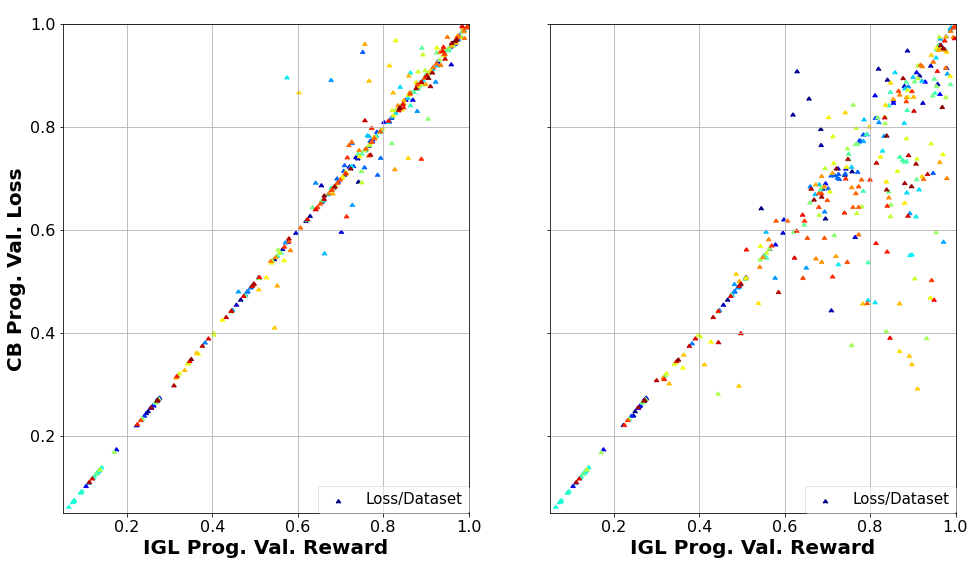

In [362]:

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9), sharey=True)    
scatter_plot(ax1, pf2.processed['igl'], pf2.processed['igl_inv'], pf.processed['cb'], color='r', label='Loss/Dataset', title='')  
ax1.set_ylabel('CB Prog. Val. Loss', fontdict= {'fontsize': 20, 'fontweight': 'bold'})


scatter_plot(ax2, pf.processed['igl_inv'], pf.processed['cb'], pf.processed['igl'], color='b', label='Loss/Dataset', title=' ')
# ax2.set_ylabel('IGL Prog. Val. Reward', fontdict= {'fontsize': 20, 'fontweight': 'bold'})
if save:
    plt.savefig(f'scatter_{datetrained}.jpg', dpi=79)
plt.show()

In [363]:
with open('../build/path_cases.txt', 'a') as f:
    for x in pathological_files:
        f.write(x+'\n')

### Aug 20 Dataset

In [364]:
class ParseLine():
    def __init__(self, oneline, examples=False, cb_flip=False):        
        self.oneline = oneline.split('\t')
        if not examples:
            self.oneline = [self.oneline[0]] + [float(x) for x in self.oneline[1:]]
        elif examples:
            if len(self.oneline)>1:
                #print(self.oneline)
                self.oneline = [self.oneline[0]] + [float(x) for x in self.oneline[2:]]
        
            
    @property
    def get_file(self):
        return self.oneline[0]
        
    @property
    def get_example(self):
        return self.oneline[1]
    
    @property
    def get_cb(self):
        return self.oneline[2]
    
    @property
    def get_cb_flip(self):
        return self.oneline[3]
        
    @property
    def get_igl(self):
        return self.oneline[4]
    
    @property
    def get_igl_inv(self):
        return self.oneline[5]

class ParseFile20(ParseLine):
    def __init__(self, filename='results_file',with_examples=False, with_cb_flip=False):  
        self.with_examples = with_examples
        self.with_cb_flip = with_cb_flip
        
        with open(filename, 'rb+') as f:
            lines = f.readlines()
        self.lines = [x.strip().decode() for x in lines  if not 'n.a.' in x.decode()]
        if with_examples:
            self.header = self.lines[:5]+[self.lines[-1]]
            self.lines = self.lines[5:-1]
            self.examples = []
        if with_cb_flip:
            self.cb_flip=[]
        
        self.processed = {}
        self.files = []
        self.cb_loss = []
        self.igl_loss = []
        self.igl_inv_loss = []
        
    def __call__(self):
        i=1
        for line in self.lines:
            i+=1
            thisline = ParseLine(line, self.with_examples, self.with_cb_flip)
            if len(thisline.oneline) <2 or 'n.a.' in thisline.oneline:
                continue
            self.files.append(thisline.get_file)
            self.cb_loss.append(thisline.get_cb)
            self.cb_flip.append(thisline.get_cb_flip)
            self.igl_loss.append(thisline.get_igl)
            self.igl_inv_loss.append(thisline.get_igl_inv)
            if self.with_examples:
                self.examples.append(thisline.get_example)
        self.processed = dict(files=self.files, examples=self.examples, cb=self.cb_loss,
                         cb_flip=self.cb_flip, igl=self.igl_loss, igl_inv=self.igl_inv_loss)
        
aug_20 = 'result_2021-08-20_17:54:18.dat'
# pf20 = ParseFile(aug_20, True)
pf20 = ParseFile20(aug_20, True, True)
pf20()

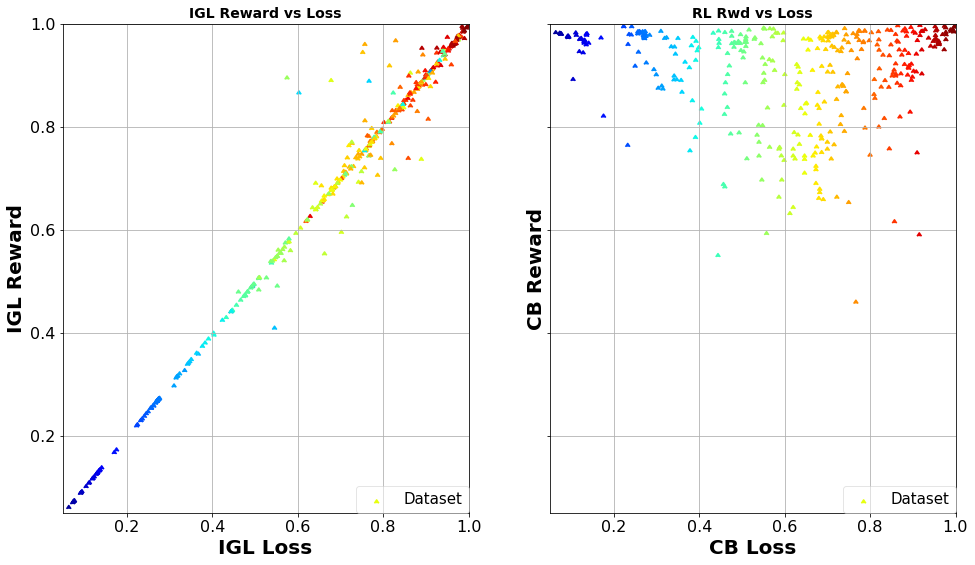

In [374]:
def scatter_plot(ax, x, y, z, label='Dataset', linestyle='-.', color='blue', title='IGL Reward vs Loss',linewidth='4', fontdict= {'fontsize': 14, 'fontweight': 'bold'}):
    ax.scatter(x, y, 20, c=z, marker=6, cmap='jet', label=label, alpha=1)
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    ax.set_xlim([0.05, 1.0])
    ax.set_ylim([0.05, 1.])
    ax.set_title(title, fontdict)
    ax.grid('on') 
    ax.legend(fancybox=True, framealpha=0.5, #bbox_to_anchor=(0, 0.0),
                     borderaxespad=0., scatterpoints=1, ncol=1,
                     loc='lower right', fontsize=15)  

pf = pf20
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9), sharey=True)    
scatter_plot(ax1, pf.igl_loss, pf.igl_inv_loss, pf.cb_loss, color='r', label='Dataset')  
ax1.set_xlabel('IGL Loss', fontdict= {'fontsize': 20, 'fontweight': 'bold'})
ax1.set_ylabel('IGL Reward', fontdict= {'fontsize': 20, 'fontweight': 'bold'})


scatter_plot(ax2, pf.cb_loss, pf.cb_flip, pf.cb_loss, color='b', label='Dataset', title='RL Rwd vs Loss')
ax2.set_xlabel('CB Loss', fontdict= {'fontsize': 20, 'fontweight': 'bold'})
ax2.set_ylabel('CB Reward', fontdict= {'fontsize': 20, 'fontweight': 'bold'})
if save:
    plt.savefig(f'scatter_{datetrained}.jpg', dpi=79)
plt.show()

In [378]:
for x in [pf20.cb_loss, pf20.cb_flip, pf20.igl_loss, pf20.igl_inv_loss]:
    print(np.mean(x))

0.6050781287878788
0.9125477323232325
0.6578272626262626
0.6598160000000001


In [390]:
for x in [pf20.cb_loss, pf20.cb_flip, pf20.igl_loss, pf20.igl_inv_loss]:
    prod = np.asarray(pf.examples) * (1-np.asarray(x))
    print(sum(prod)/sum(pf.examples))

0.4615425693656812
0.03254757715022832
0.4437562811390282
0.4438666430115347
